In [4]:
#prepare dataset

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

loan_df = pd.read_csv("loan_features.csv")

X = loan_df.drop(columns=['loan_status'])
y = loan_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
#Baseline – Logistic Regression
#Logistic Regression gives probabilities, interpretable coefficients → classic baseline in credit scoring.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Example: scale numeric features only (for LR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['float64','int64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64','int64']))

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7000
           1       0.60      0.92      0.73      2000

    accuracy                           0.85      9000
   macro avg       0.79      0.87      0.81      9000
weighted avg       0.89      0.85      0.86      9000

ROC-AUC: 0.9485135714285714


In [10]:
#Boosting Models – XGBoost / LightGBM

#Handle tabular + categorical well.
#Capture non-linear interactions (like income + intent).
#Usually best performance.

In [12]:
# Convert object columns to category dtype
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

xgb_clf = xgb.XGBClassifier(
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    enable_categorical=True,    # ✅ important
    random_state=42
)

xgb_clf.fit(X_train, y_train)
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]))


C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:06:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC-AUC: 0.9785594285714285


In [13]:
#Calibration of Probabilities

#Critical in credit risk: bank decisions depend on probability of default (PD), not just class labels.
#Use Platt scaling (sigmoid) or Isotonic regression.

In [15]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgb = CalibratedClassifierCV(estimator=xgb_clf, method='isotonic', cv=5)
calibrated_xgb.fit(X_train, y_train)

y_proba_cal = calibrated_xgb.predict_proba(X_test)[:,1]
print("Calibrated ROC-AUC:", roc_auc_score(y_test, y_proba_cal))


C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:09:19] WARNING: C:\actions-runner\_work\xgbo

Calibrated ROC-AUC: 0.9796842857142858


In [16]:
#Explainability – SHAP
#Shows feature contribution for each borrower.

C:\Users\shiks\Documents\fraud-loans-project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


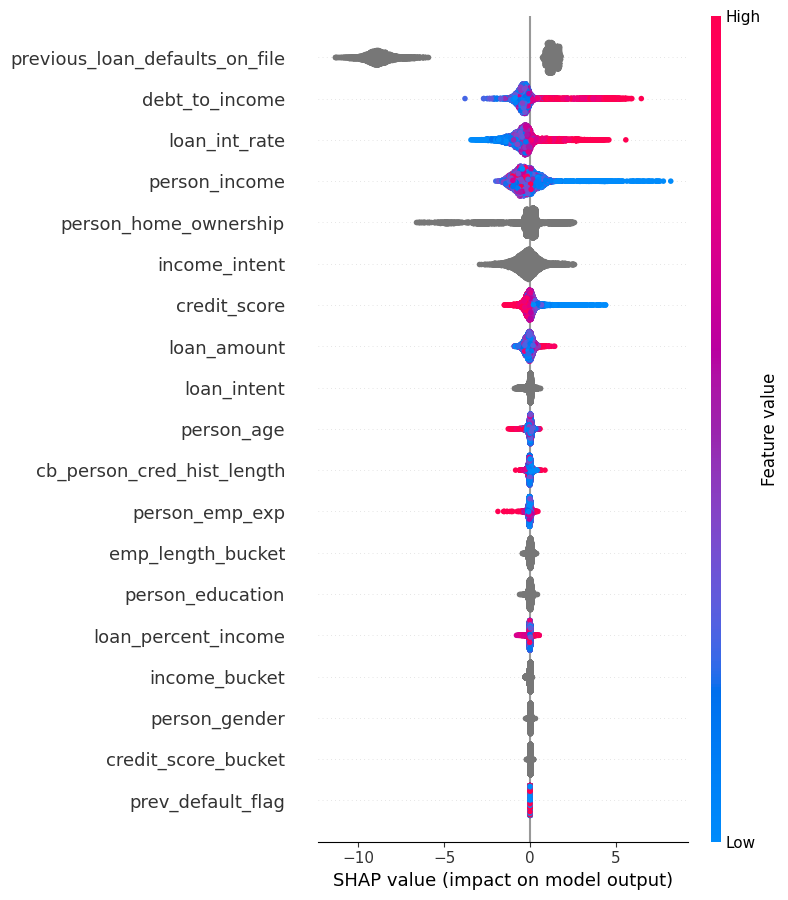

In [17]:
import shap

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


#### Insights 

1. Logistic Regression → Baseline, interpretable, probabilities but limited on non-linear effects.

2. Boosting models (XGBoost/LightGBM) → Higher predictive power, best performance.

3. Calibration → Adjust raw model outputs into well-calibrated PD (probability of default) → critical for lending.

4. Explainability (SHAP) → Helps regulators and business trust the model (see which factors lead to high risk).

5. Business Impact → Using these models, lenders can rank customers by risk, approve safer loans, and reduce default losses.

In [18]:
#Loan Evaluation (Credit Scoring)

#Loans dataset is more balanced than fraud, so ROC-AUC + calibration is useful.

ROC-AUC: 0.9785594285714285


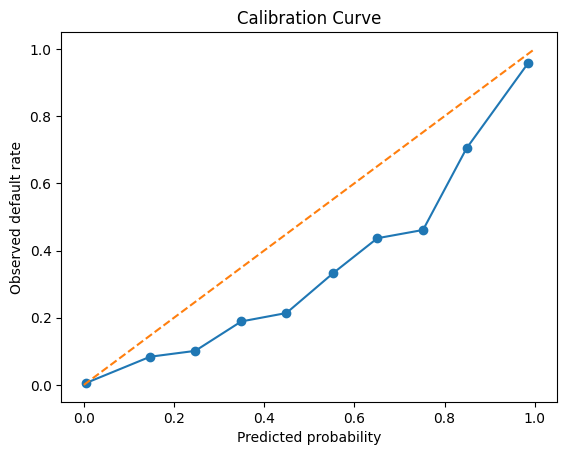

In [19]:
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# ROC-AUC
y_scores = xgb_clf.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_scores))

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_scores, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration Curve")
plt.show()


In [20]:
#Cross-Validation Strategy

#Loans (customer-level, not time-dependent):Use Stratified k-Fold CV to preserve default ratio.

In [22]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# Fit and evaluate model
